In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.decomposition import PCA

### Import MNIST data set

### Import cats and dogs data set

In [23]:
catdogdata = pd.read_csv('catdogdata.txt', sep=' ').values

labels_cd = np.zeros(catdogdata.shape[0])
labels_cd[99:] = 1

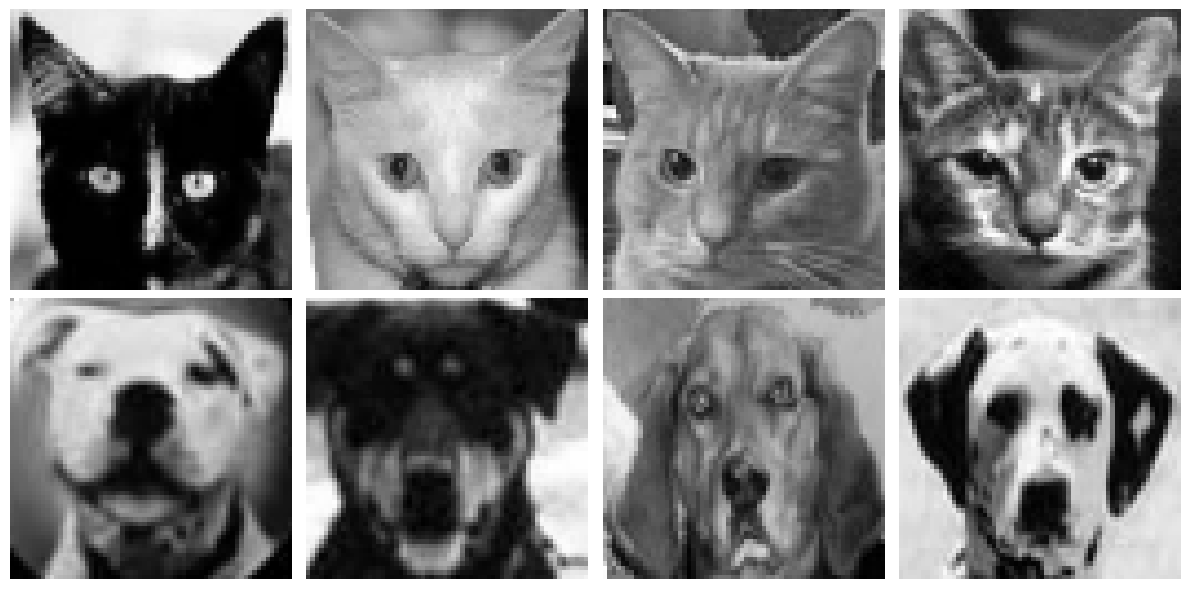

In [ ]:
def rotateM(img):
    return np.rot90(img, k=-1)

np.random.seed(1000012)

ssc = np.random.choice(np.where(labels_cd == 0)[0], 4, replace=False) 
ssd = np.random.choice(np.where(labels_cd == 1)[0], 4, replace=False)


fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, idx in enumerate([ssc[0], ssc[1], ssc[2], ssc[3], ssd[0], ssd[1], ssd[2], ssd[3]]):
    img = catdogdata[idx].reshape(64, 64)
    img = rotateM(img)
    ax = axes[i // 4, i % 4]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Part 1: explore at least 3 different classifiers and at least two feature selection methods.

In [37]:
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


feature_range = np.arange(5, 4096, 100)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for clf_name, clf in classifiers.items():
    results[clf_name] = {"best_score": 0, "best_k": 0, "scores": []}
    print(f"\nClassifier: {clf_name}")
    for k in feature_range:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('selector', SelectKBest(score_func=f_classif, k=k)),
            ('classifier', clf)
        ])
        scores = cross_val_score(pipeline, catdogdata, labels_cd, cv=cv, scoring='accuracy')
        mean_score = scores.mean()
        print(f"  k={k} -> Accuracy: {mean_score:.4f}")
        results[clf_name]["scores"].append((k, mean_score))
        if mean_score > results[clf_name]["best_score"]:
            results[clf_name]["best_score"] = mean_score
            results[clf_name]["best_k"] = k

print("\n==== Best Results ====")
for clf_name in classifiers:
    print(f"{clf_name}: Best Accuracy = {results[clf_name]['best_score']:.4f} with k = {results[clf_name]['best_k']}")


Classifier: KNN
  k=5 -> Accuracy: 0.6769
  k=105 -> Accuracy: 0.6868
  k=205 -> Accuracy: 0.7419
  k=305 -> Accuracy: 0.7929
  k=405 -> Accuracy: 0.8277
  k=505 -> Accuracy: 0.8178
  k=605 -> Accuracy: 0.8385
  k=705 -> Accuracy: 0.8335
  k=805 -> Accuracy: 0.8382
  k=905 -> Accuracy: 0.8231
  k=1005 -> Accuracy: 0.8329
  k=1105 -> Accuracy: 0.8379
  k=1205 -> Accuracy: 0.8379
  k=1305 -> Accuracy: 0.8277
  k=1405 -> Accuracy: 0.8126
  k=1505 -> Accuracy: 0.8128
  k=1605 -> Accuracy: 0.8331
  k=1705 -> Accuracy: 0.8279
  k=1805 -> Accuracy: 0.8227
  k=1905 -> Accuracy: 0.8228
  k=2005 -> Accuracy: 0.8178
  k=2105 -> Accuracy: 0.8127
  k=2205 -> Accuracy: 0.8279
  k=2305 -> Accuracy: 0.8178
  k=2405 -> Accuracy: 0.8179
  k=2505 -> Accuracy: 0.8281
  k=2605 -> Accuracy: 0.8281
  k=2705 -> Accuracy: 0.8231
  k=2805 -> Accuracy: 0.8281
  k=2905 -> Accuracy: 0.8279
  k=3005 -> Accuracy: 0.8179
  k=3105 -> Accuracy: 0.8229
  k=3205 -> Accuracy: 0.8177
  k=3305 -> Accuracy: 0.8177
  k=3405 

In [35]:
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

num_repeats = 10
k_list = [300, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
cv_folds = 5

heatmaps = {clf_name: {k: np.zeros(4096) for k in k_list} for clf_name in classifiers}

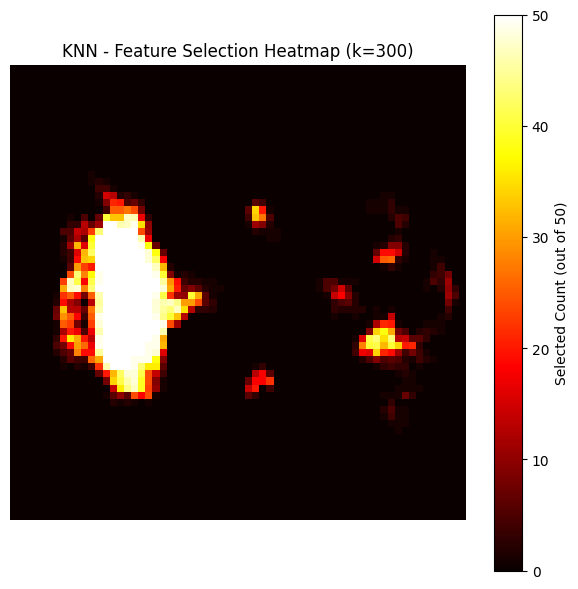

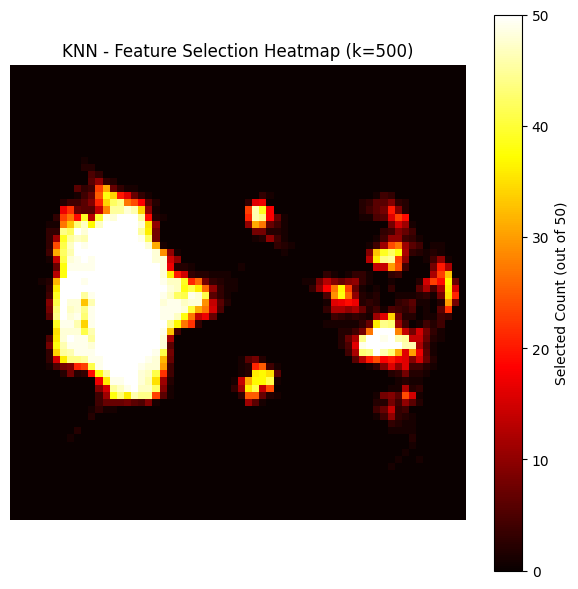

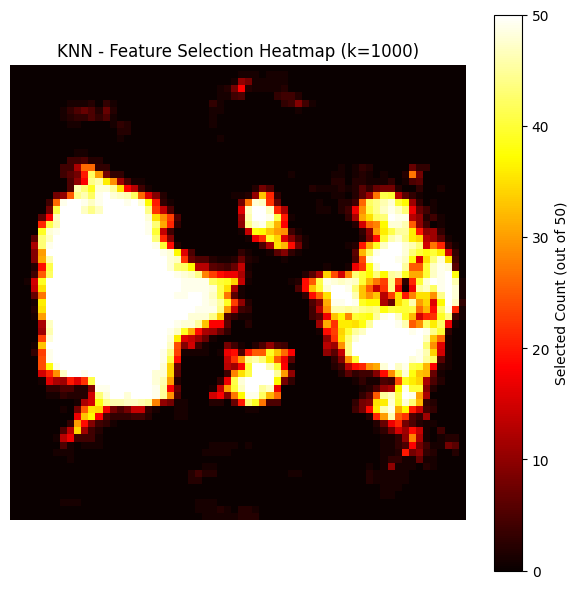

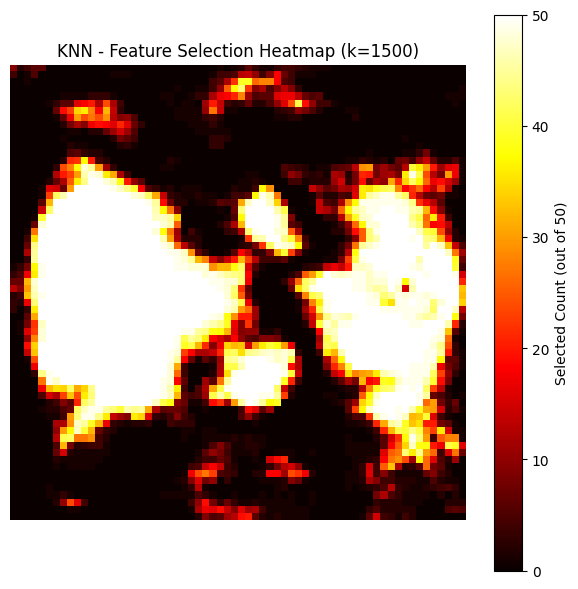

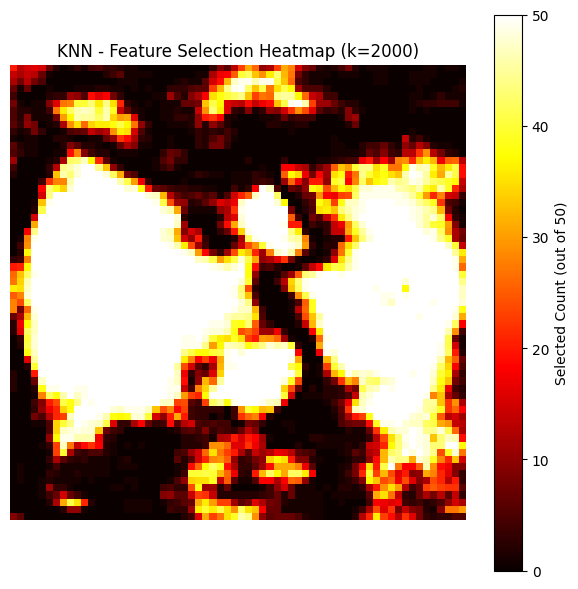

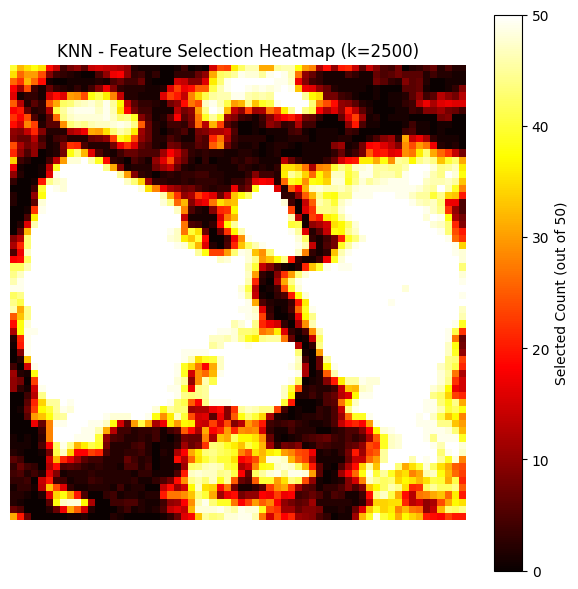

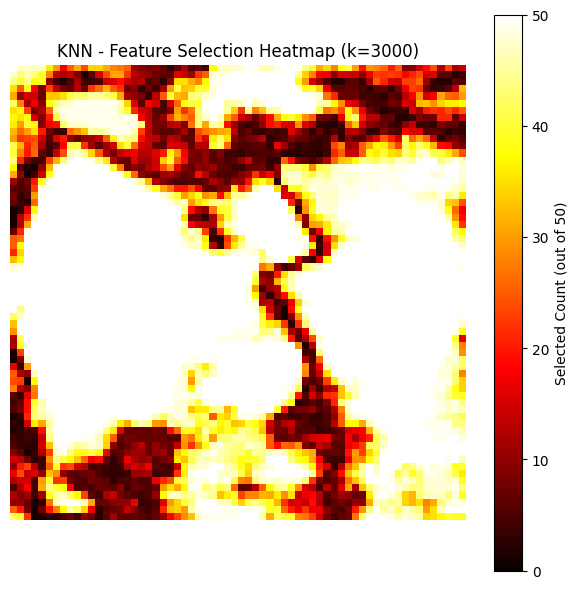

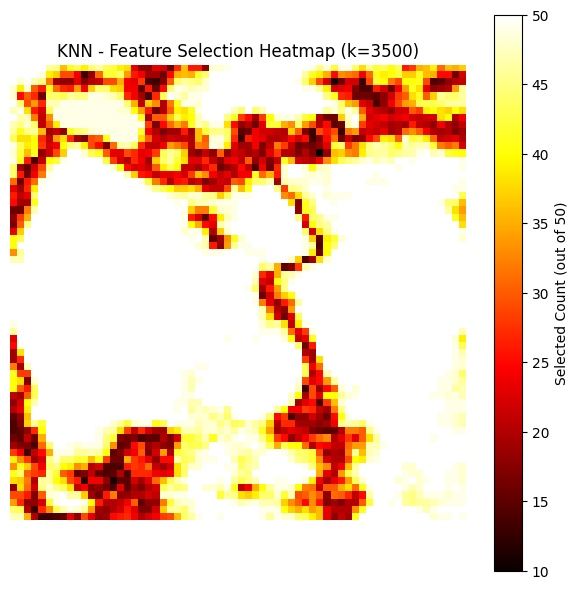

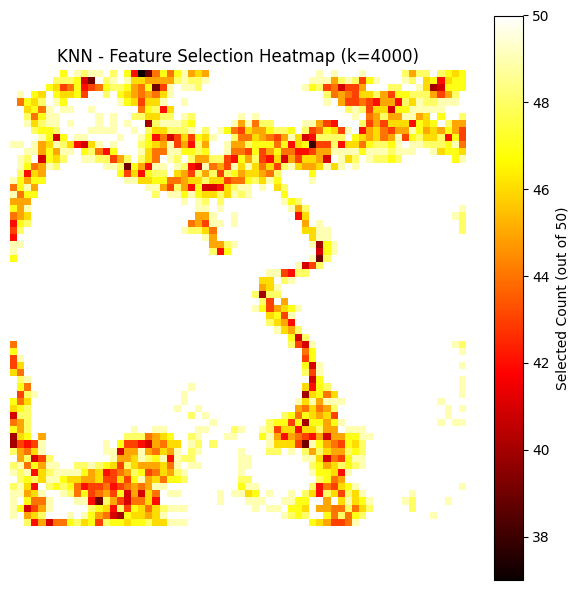

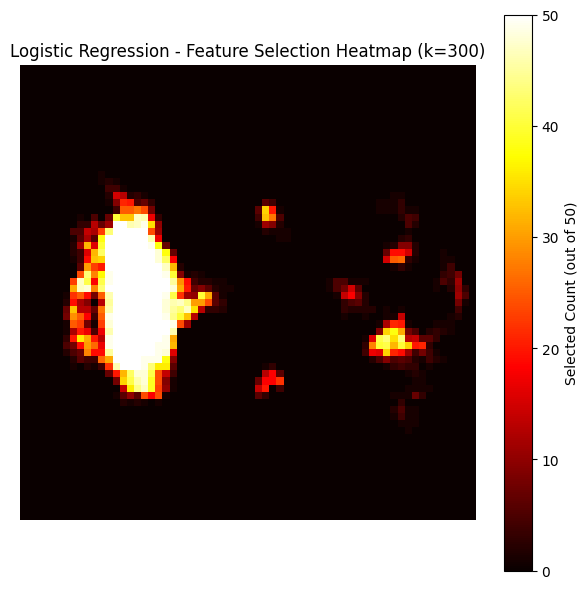

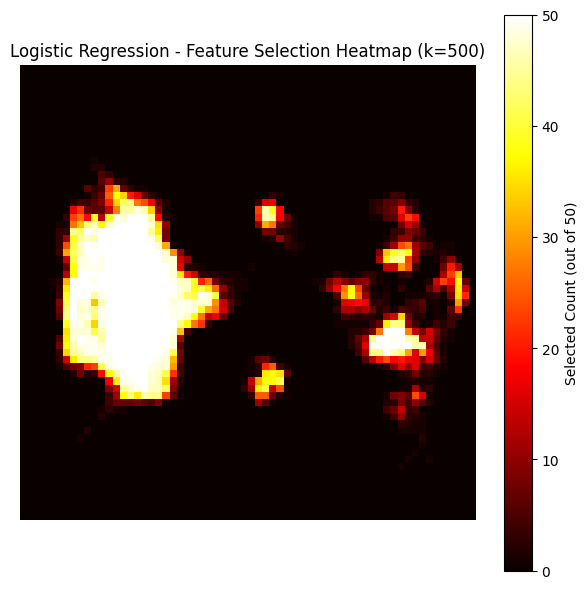

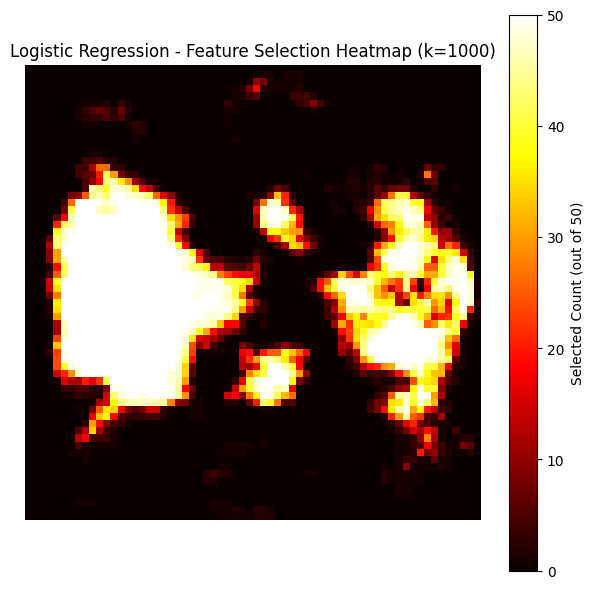

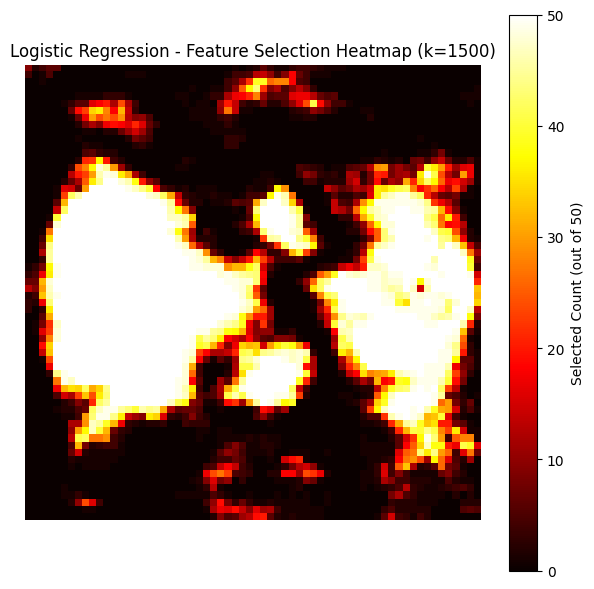

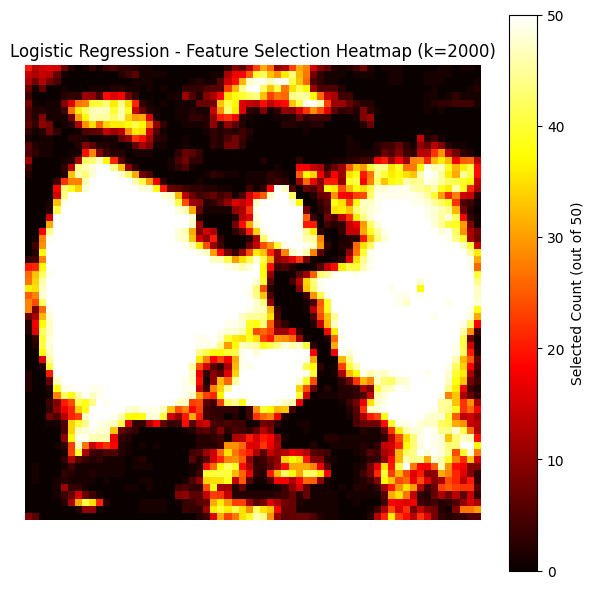

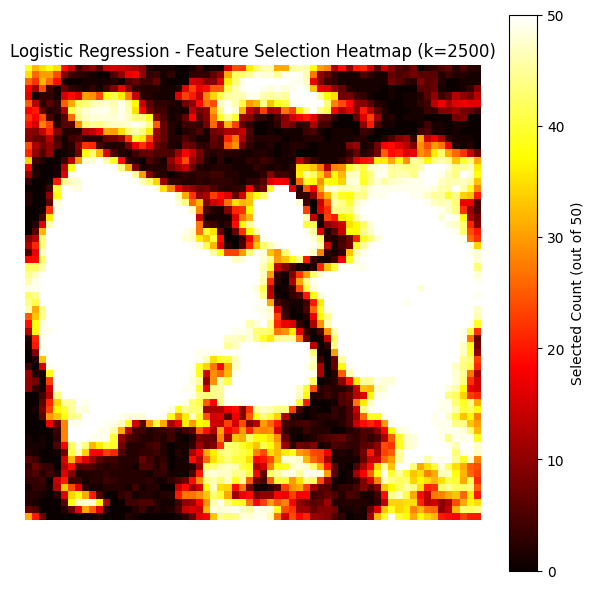

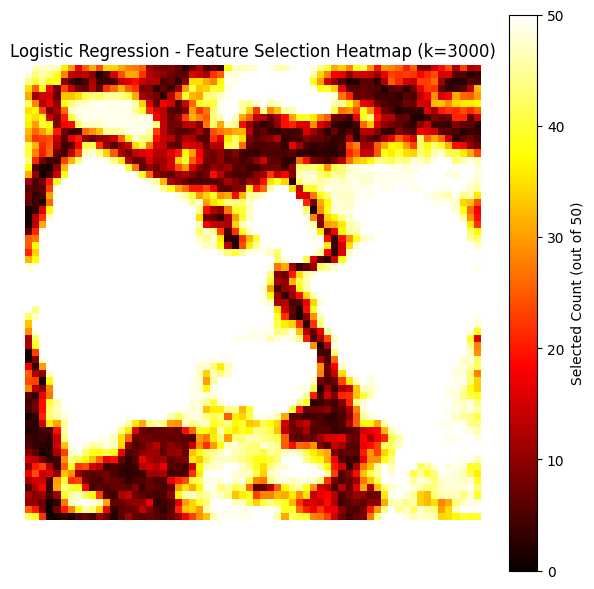

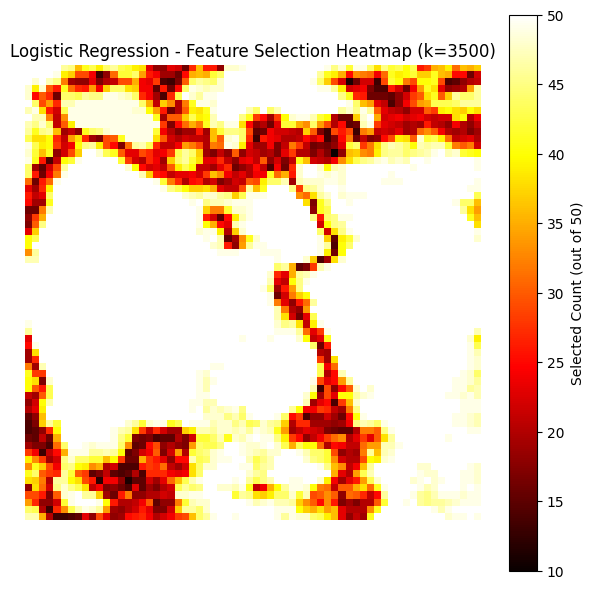

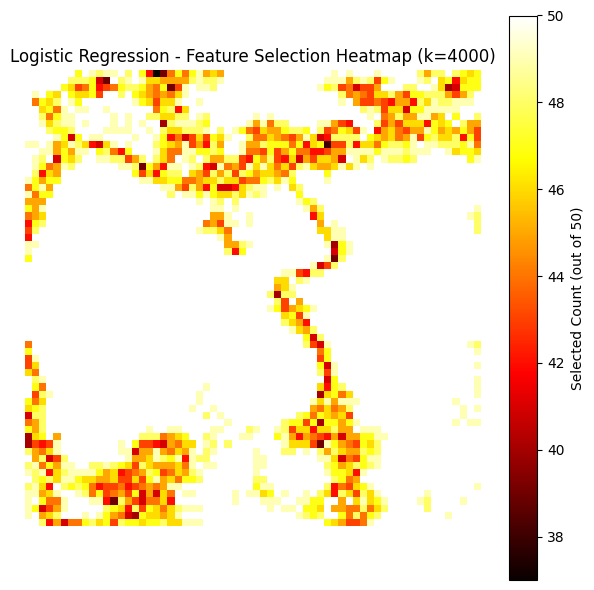

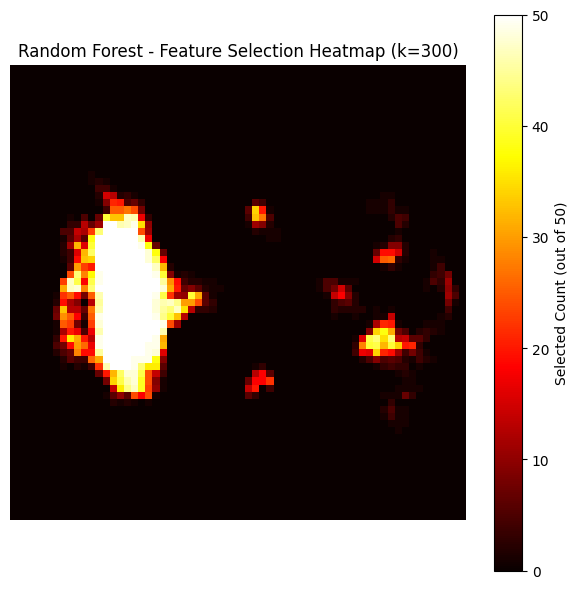

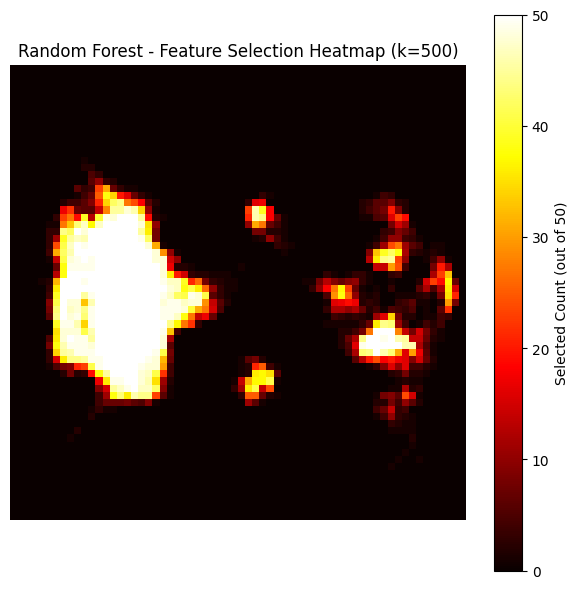

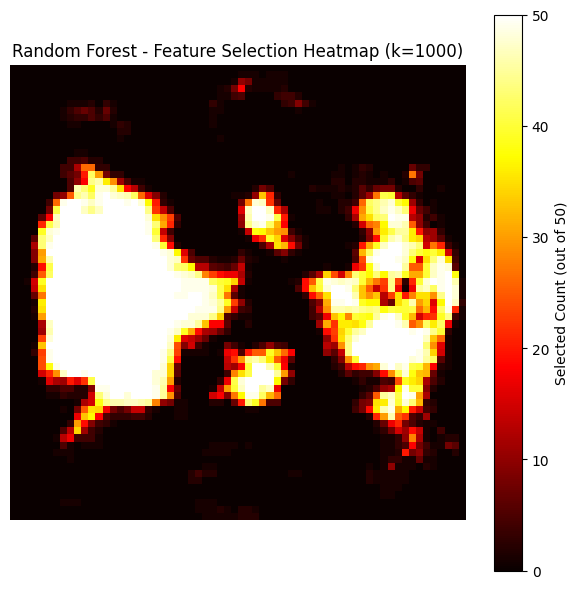

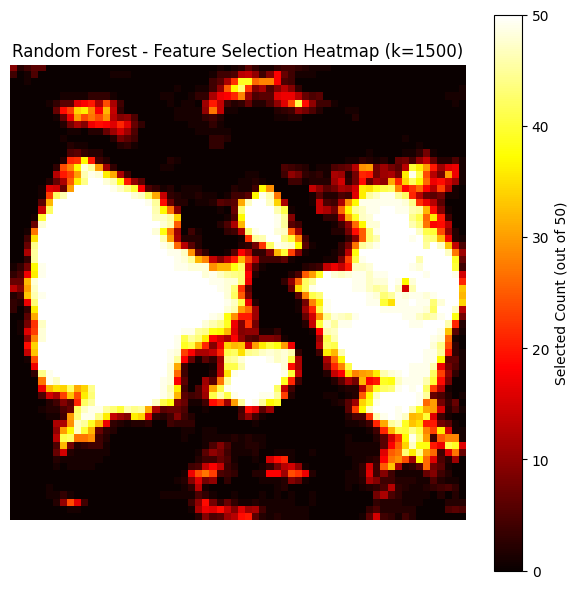

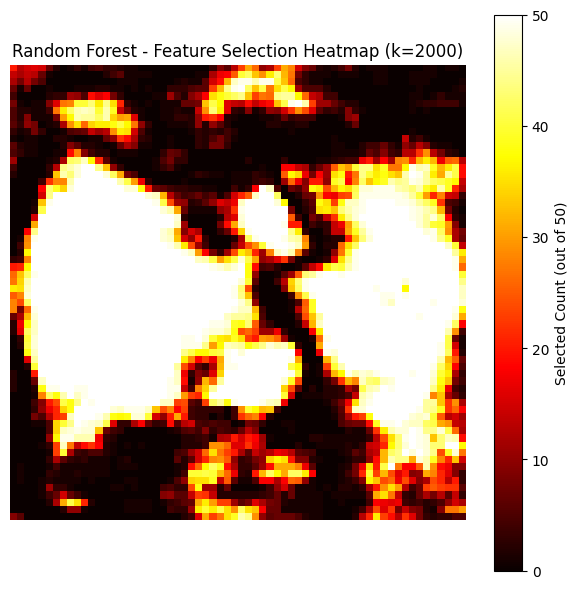

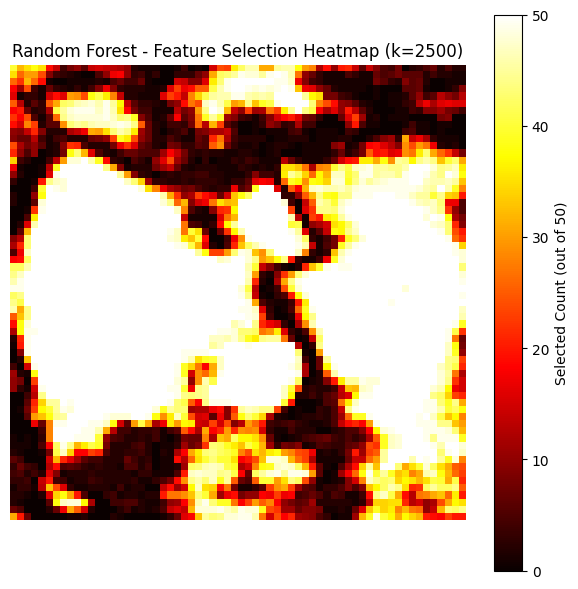

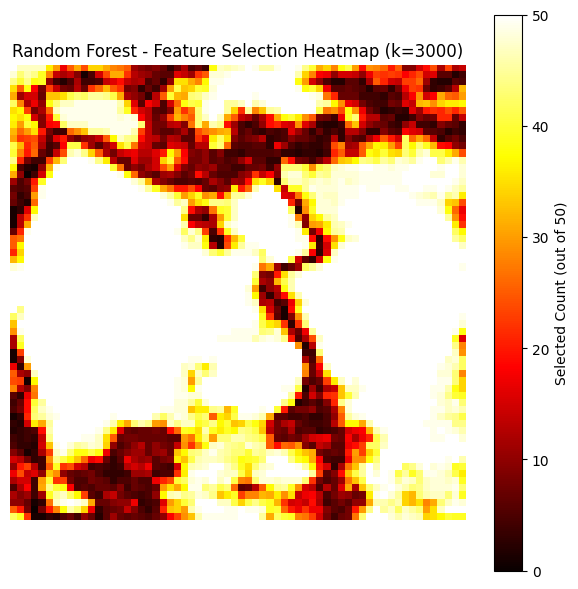

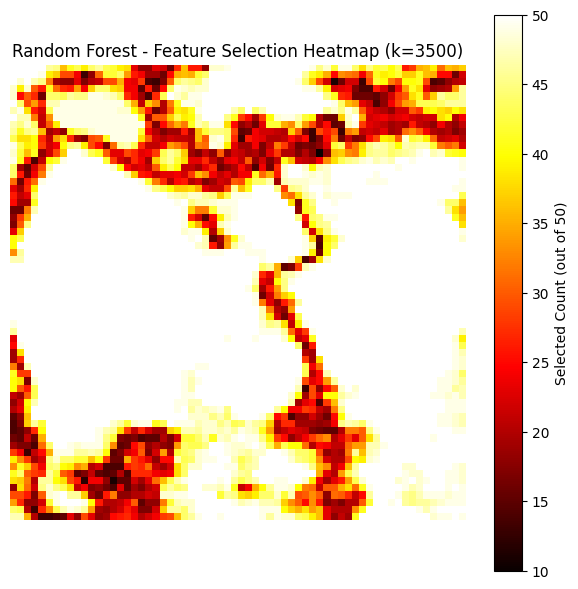

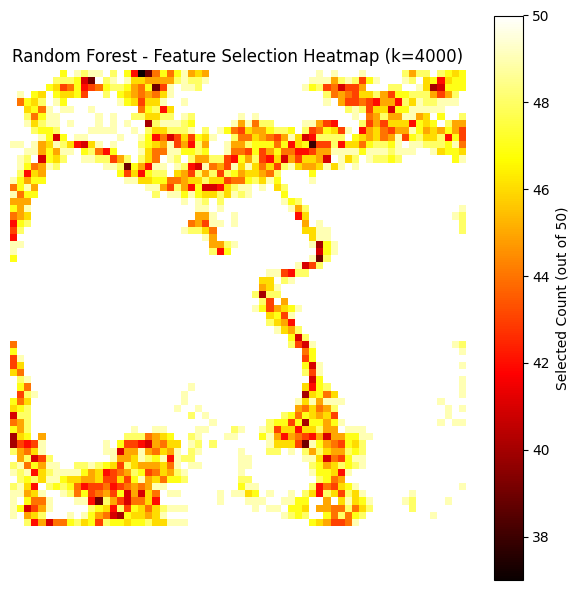

In [36]:
for run in range(num_repeats):
    np.random.seed(42 + run)
    idx = np.random.permutation(len(labels_cd))
    X, y = catdogdata[idx], labels_cd[idx]

    for clf_name, clf in classifiers.items():
        for k in k_list:
            selector_counts = Counter()
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42 + run)
            for train_idx, test_idx in cv.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                pipe = Pipeline([
                    ('scaler', StandardScaler()),
                    ('selector', SelectKBest(score_func=f_classif, k=k)),
                    ('classifier', clf)
                ])  
                pipe.fit(X_train, y_train)
                selector = pipe.named_steps['selector']
                selected_features = selector.get_support(indices=True)
                for feat in selected_features:
                    heatmaps[clf_name][k][feat] += 1


for clf_name in classifiers:
    for k in k_list:
        heatmap_image = heatmaps[clf_name][k].reshape(64, 64)
        plt.figure(figsize=(6, 6))
        plt.imshow(heatmap_image, cmap='hot')
        plt.colorbar(label=f'Selected Count (out of {num_repeats * cv_folds})')
        plt.title(f"{clf_name} - Feature Selection Heatmap (k={k})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()